In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import riskfolio.Portfolio as pf
import riskfolio.PlotFunctions as plf
import riskfolio.RiskFunctions as rf
import matplotlib as plt
import  statsmodels .api  as  sm 
from  sklearn.linear_model  import  LinearRegression
import  cvxpy  as  cv
from scipy.stats import norm

from finquant.portfolio import *
from finquant.moving_average import compute_ma, ema

import quantstats as qs

In [2]:
df_health = pd.read_csv('tick_score_health.csv')
df_tech = pd.read_csv('tick_score_tech.csv')
df_durable = pd.read_csv('tick_score_durable.csv')
df_nondurable = pd.read_csv('tick_score_nondurable.csv')
df_capital = pd.read_csv('tick_score_capital.csv')
df_transport = pd.read_csv('tick_score_transport.csv')
df_util = pd.read_csv('tick_score_util.csv')
df_services = pd.read_csv('tick_score_services.csv')
df_energy = pd.read_csv('tick_score_energy.csv')
df_finance = pd.read_csv('tick_score_finance.csv')
df_basics = pd.read_csv('tick_score_basics.csv')


frames = [df_finance, df_capital, df_durable, df_energy, df_health, df_nondurable, df_services, df_tech, df_services, df_util, df_basics]
df = pd.concat(frames)
df = df.drop_duplicates(subset=['Unnamed: 0'], keep='last')
df = df.set_index("Unnamed: 0")

percentile = np.percentile(df['Score'], 90)
mu, std = norm.fit(df['Score'])
roc = std / 3
aplus = df[df['Score'] > mu + (roc*4)]
#aplus = df[df['Score'] > mu + (roc*6)]
tickers = aplus.index

In [3]:
start = "2016-01-01"
end = "2020-12-30"

# Tickers of assets
assets = list(tickers)
assets.sort()

In [4]:
data = yf.download(assets, start = start, end = end, threads = False)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

market_data = yf.download("^GSPC", start = start, end = end, threads = False)
market_data = market_data.loc[:,('Adj Close')]

[*********************100%***********************]  48 of 48 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
port_diff = data[assets].pct_change().dropna()
mkt_diff = market_data.pct_change().dropna()

In [6]:
################################################## ####################### 
# Calculating the Betas 
######################## ################################################ 

# Using statsmodels 
x = mkt_diff.values 
x = sm.add_constant(x)

Beta_1  =  [] 
for i in assets:
    y_i =  port_diff[i].values 
    mod =  sm.OLS(y_i, x) 
    res =  mod.fit() 
    Beta_1.append(res.params[1])

Beta_1 = np.matrix(Beta_1)

# Using scikit learn 
y = port_diff.values 
x = mkt_diff.values
lst = []
for i in mkt_diff.values:
    lst.append([i])

x = lst
reg = LinearRegression().fit(x, y)
Beta_2 = np.matrix(reg.coef_).T

# Combining both betas to show them 
B1 = pd.DataFrame(Beta_1.T, index = assets, columns = ['Beta_1']) 
B2 = pd.DataFrame(Beta_2.T, index = assets, columns = ['Beta_2'])

B1_B2 = pd.concat([B1, B2], axis = 1)


In [7]:
################################################## ####################### 
# Calculating the vector of means and the matrix of covariances from 
# the CAPM model 
########### ################################################## ###########

Sigma_rm = np.matrix(np.var(mkt_diff, ddof = 1))

x = mkt_diff.values 
x = sm.add_constant(x)

mu_F_1 = []
Sigma_e_1 = []
for i in assets:
    y_i = port_diff[i].values
    mod = sm.OLS(y_i, x)
    res = mod.fit()
    error = np.matrix(y_i) - np.matrix(res.predict(x))
    mu_F_1.append(np.mean(res.predict(x), axis = 0))
    Sigma_e_1.append(np.asscalar(np.var(error.T, ddof = 1, axis = 0)))

mu_F_1 = np.matrix(mu_F_1)
Sigma_e_1 = np.diag(Sigma_e_1)
Sigma_F_1 = Beta_2.T * Sigma_rm *  Beta_2 + Sigma_e_1

#display(pd.DataFrame(mu_F_1, columns = assets))
#display(pd.DataFrame(Sigma_F_1, index = assets, columns = assets))

<ipython-input-7-521761541ad5>:19: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  Sigma_e_1.append(np.asscalar(np.var(error.T, ddof = 1, axis = 0)))


In [8]:
x = mkt_diff.values
lst = []
for i in mkt_diff.values:
    lst.append([i])

x = lst
error_2 = y - reg.predict(x)

mu_F_2 = np.matrix(np.mean(reg.predict(x), axis = 0))
Sigma_e_2 = np.diag(np.var(error_2, ddof = 1, axis = 0))
Sigma_F_2 = Beta_2.T * Sigma_rm *  Beta_2 + Sigma_e_2

#display(pd.DataFrame(mu_F_2, columns = assets))
#display(pd.DataFrame(Sigma_F_2, index = assets, columns = assets))

In [9]:
################################################## ###################### 
# Calculating optimal portfolios with historical estimates 
# and CAPM estimates 
############# ################################################## #########

# Defining the optimization function 
def Max_Sharpe(mu, Sigma):
    w = cv.Variable((mu.shape[1], 1))
    k = cv.Variable(1)
    rf = cv.Parameter(nonneg=True)
    rf.value=0
    #defining the problem, objective function and    
    constraints = [(mu - rf)*w == 1,
                   w >= 1e-10,
                   k >= 1e-10,
                   cv.sum(w) == k]
    prob = cv.Problem(cv.Minimize(cv.quad_form(w, Sigma)), constraints)
    #solving the problem
    prob.solve(solver=cv.ECOS)

    return np.matrix(w.value/k.value)

mu = np.matrix(np.mean(port_diff.values, axis = 0))
Sigma = np.cov(port_diff.values.T)

w1 = Max_Sharpe(mu, Sigma)
w2 = Max_Sharpe(mu_F_2, Sigma_F_2)



W1 = pd.DataFrame(w1, index = assets, columns = ['Historical'])
W2 = pd.DataFrame(w2, index = assets, columns = ['CAPM'])

display(pd.concat([W1, W2], axis = 1).applymap("{0:.2%}".format))

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.war

Historical    CAPM
ABBV      0.34%   0.00%
APD       0.00%   0.00%
AZO       0.00%   0.00%
BA        0.00%   0.00%
BCE       0.00%   0.00%
BEN       0.00%   0.00%
BKNG      0.00%   0.00%
BTI       0.00%   0.00%
CL        0.00%   0.00%
CLX      12.15%  13.96%
CMI       6.74%   0.00%
D         0.00%   0.00%
DEO       0.00%   0.00%
DPZ      19.22%  20.83%
DVN       0.00%   0.00%
EL       10.59%   7.12%
EMR       0.00%   0.00%
EOG       0.00%   0.00%
FANG      0.00%   0.00%
GILD      0.00%   0.00%
HCA       0.00%   0.00%
HON       0.00%   0.00%
IDXX     35.70%  34.32%
IFF       0.00%   0.00%
IHG       0.00%   0.00%
IQV       0.00%   0.00%
JHX       0.00%   0.00%
KDP      10.68%  12.99%
KEP       0.00%   0.00%
KMB       0.00%   0.00%
KO        0.00%   0.00%
LIN       2.63%   0.00%
LNG       0.00%   0.00%
LYB       0.00%   0.00%
MCO       0.00%   0.00%
MDLZ      0.00%   0.00%
MTD       1.94%   9.33%
NGG       0.00%   0.00%
OXY       0.00%   0.00%
PEP       0.00%   0.00%
PM        0.00%   0.00%
PPG       0.00%   0.00%
PSX       0.00%   0.00%
SPG       0.00%   0.00%
SPGI      0.00%   1.45%
TRV       0.00%   0.00%
VRSN      0.00%   0.00%
YUM       0.00%   0.00%

In [10]:
import riskfolio.Portfolio as pf
import riskfolio.PlotFunctions as plf
import matplotlib as plt

In [11]:
W2_dup = W2.reset_index()
W2_dup.columns = ["Name", "Allocation"]
print(W2_dup)
df_pf_CAPM = build_portfolio(names=list(W2.index), start_date = start, end_date = end, data_api="yfinance", pf_allocation = W2_dup)

print(f"Sharpe Ratio: {df_pf_CAPM.comp_sharpe()}")


    Name    Allocation
0   ABBV  2.819126e-07
1    APD  7.499490e-09
2    AZO  5.435875e-09
3     BA  2.093622e-09
4    BCE  4.389717e-09
5    BEN  1.486837e-09
6   BKNG  3.089894e-09
7    BTI  2.513336e-09
8     CL  5.776029e-09
9    CLX  1.395887e-01
10   CMI  2.496955e-07
11     D  4.355714e-09
12   DEO  6.523399e-09
13   DPZ  2.083169e-01
14   DVN  1.042359e-09
15    EL  7.122437e-02
16   EMR  3.044275e-09
17   EOG  1.399257e-09
18  FANG  1.516007e-09
19  GILD  2.009669e-09
20   HCA  1.089188e-08
21   HON  5.352778e-09
22  IDXX  3.431857e-01
23   IFF  2.291709e-09
24   IHG  2.785422e-09
25   IQV  5.339505e-09
26   JHX  6.502818e-09
27   KDP  1.298735e-01
28   KEP  1.739226e-09
29   KMB  5.043953e-09
30    KO  4.961145e-09
31   LIN  5.643425e-08
32   LNG  3.687603e-09
33   LYB  1.733056e-09
34   MCO  5.676275e-09
35  MDLZ  3.605498e-09
36   MTD  9.333161e-02
37   NGG  3.430483e-09
38   OXY  8.910091e-10
39   PEP  5.835400e-09
40    PM  3.153707e-09
41   PPG  3.149219e-09
42   PSX  1

[*********************100%***********************]  4 of 4 completed


PRWAX    66.169272
SWPPX    83.268981
WFIVX    42.547109
^GSPC    85.179811
dtype: float64

PRWAX       SWPPX       WFIVX       ^GSPC
Date                                                      
2016-01-05   99.975533  100.193048  100.171335  100.201223
2016-01-06   99.021523   98.938224   98.914903   98.887044
2016-01-07   96.061642   96.589448   96.516273   96.543377
2016-01-08   95.009783   95.527672   95.431176   95.497004
2016-01-11   94.863008   95.624194   95.431176   95.578489
...                ...         ...         ...         ...
2020-12-22  164.995096  181.306302  143.061102  183.203320
2020-12-23  165.092945  181.435005  143.232436  183.339955
2020-12-24  165.166328  182.110678  143.632206  183.988354
2020-12-28  166.071423  183.687260  144.545969  185.593197
2020-12-29  166.169272  183.268981  142.547109  185.179811

[1256 rows x 4 columns]

Date
2016-01-05    100.966344
2016-01-06    100.398352
2016-01-07     98.319524
2016-01-08     98.211728
2016-01-11     97.485189
                 ...    
2020-12-22    433.421317
2020-12-23    434.367435
2020-12-24    435.484982
2020-12-28    435.449834
2020-12-29    431.601110
Length: 1256, dtype: float64


<AxesSubplot:xlabel='Date'>

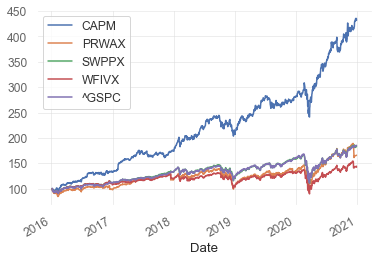

In [12]:
comparisons = ["^GSPC", "WFIVX", "PRWAX", "SWPPX"]
sp_500 = yf.download(tickers=comparisons, start=start, end=end, threads = False)
sp_500 = sp_500.loc[:,('Close')]
sp_500_total_cum_return = ((sp_500.iloc[-1] - sp_500.iloc[0]) / sp_500.iloc[0])*100
display(sp_500_total_cum_return)
sp_500_daily = sp_500.pct_change().fillna(100)[1:]
compare_port = (sp_500_daily + 1).cumprod()
compare_port *= 100
compare_port = pd.DataFrame(compare_port)
display(compare_port)

Y_cum = data[assets].pct_change().fillna(0)[1:]
for tick in W2.index:
    Y_cum.loc[:,tick] *= W2.loc[tick].values
port_ret = Y_cum.sum(axis=1)
Y_cum_ret = (port_ret + 1).cumprod()
Y_cum_ret *= 100
print(Y_cum_ret)



pfcr = pd.DataFrame(Y_cum_ret)
pfcr.columns = ["CAPM"]
newdf = pfcr.join(compare_port)

newdf.plot()

                    Strategy
------------------  ----------
Start Period        2016-01-05
End Period          2020-12-29
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   331.6%
CAGR%               34.08%

Sharpe              1.67
Sortino             2.44
Sortino/√2          1.73

Max Drawdown        -21.81%
Longest DD Days     203

Gain/Pain Ratio     0.36
Gain/Pain (1M)      5.47

Payoff Ratio        1.02
Profit Factor       1.36
Common Sense Ratio  1.42
CPC Index           0.79
Tail Ratio          1.05
Outlier Win Ratio   4.18
Outlier Loss Ratio  3.88

MTD                 2.93%
3M                  12.85%
6M                  26.74%
YTD                 53.58%
1Y                  53.17%
3Y (ann.)           34.83%
5Y (ann.)           34.08%
10Y (ann.)          34.08%
All-time (ann.)     34.08%

Avg. Drawdown       -2.03%
Avg. Drawdown Days  15
Recovery Factor     15.21
Ulcer Index         1.01


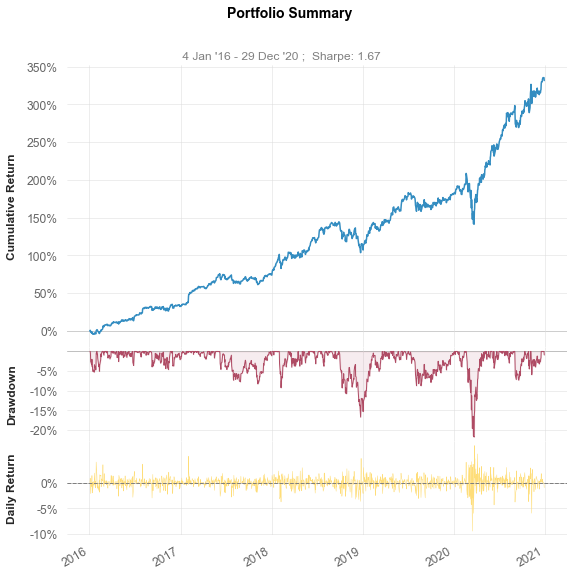

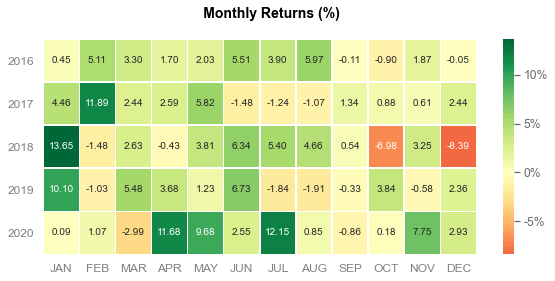

In [13]:
qs.reports.basic(port_ret)

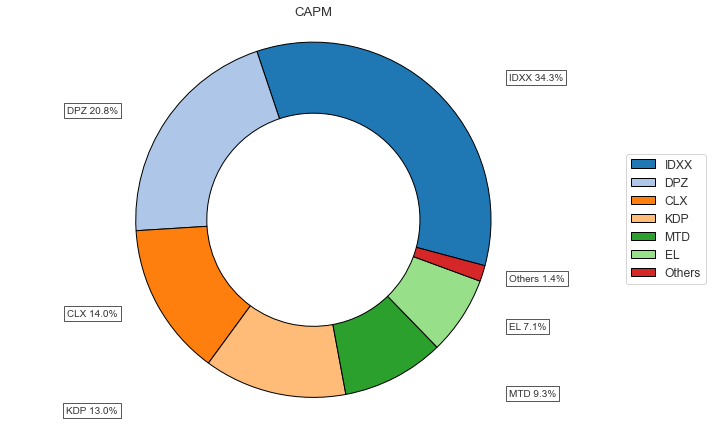

In [14]:
ax = plf.plot_pie(w=W2, title='CAPM', others=0.05, nrow = 25, cmap = "tab20", height=6, width=10, ax=None)

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)


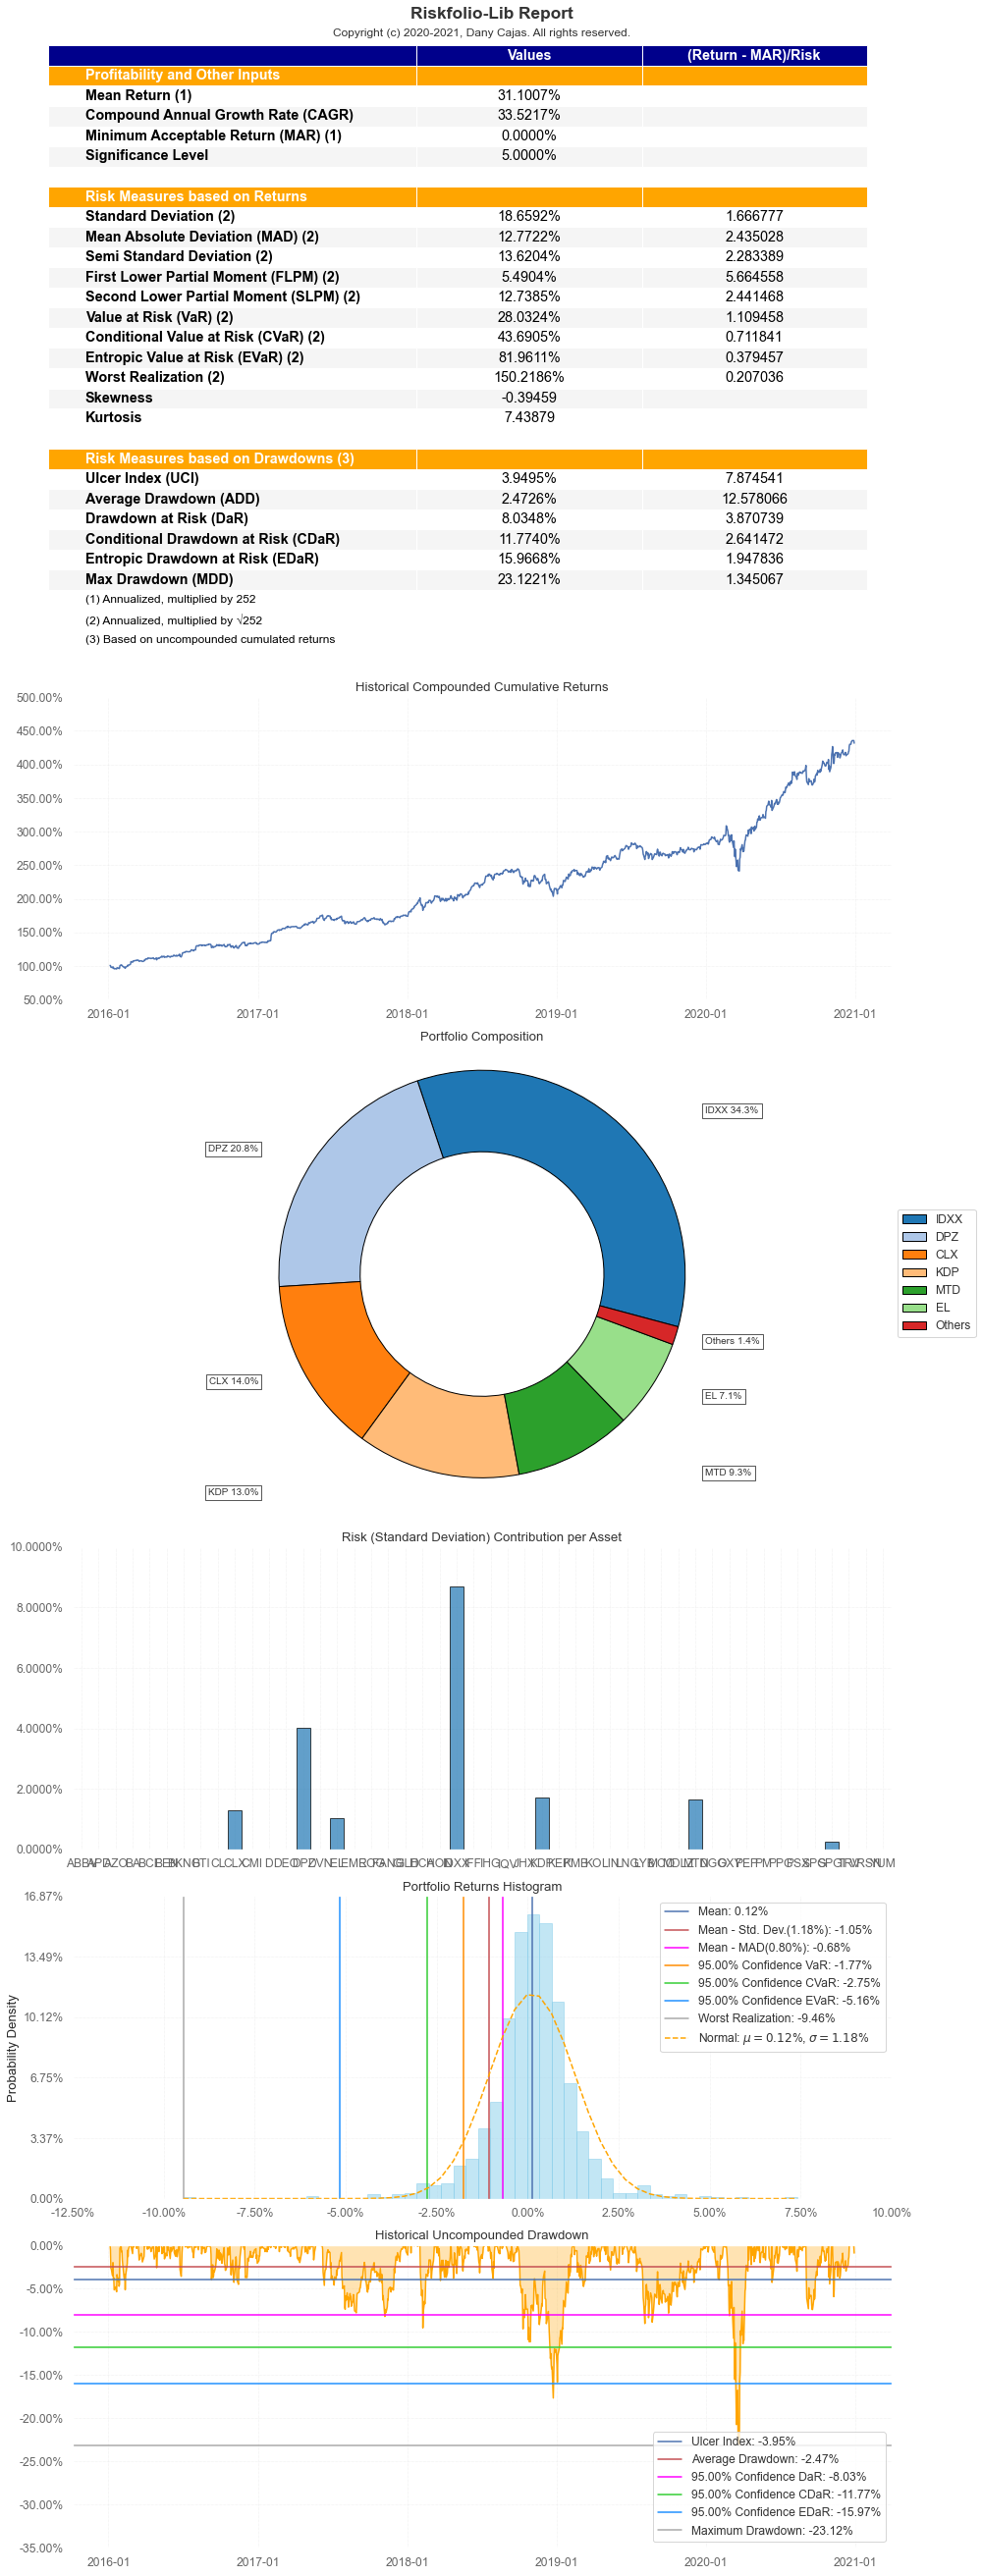

In [15]:
import riskfolio.Reports as rp

ax_report = rp.jupyter_report(port_diff, w=W2, rm='MV', rf=0, alpha=0.05, height=6, width=14,
                       others=0.05, nrow=25)

In [16]:
################################################## ###################### 
# Calculating the vector of means and the matrix of covariances from 
# the CAPM model 
############ ################################################## ###########

# Loading the information of the factors 
#dt.date
three_factor = pd.read_csv('FF_three.csv', index_col=0, header=0)/100
three_factor = three_factor.loc[start: end][:-2]
x = three_factor[['Mkt-RF', 'SMB', 'HML']].values
#display(three_factor)
y = port_diff.values
reg = LinearRegression().fit(x, y)
B = np.matrix(reg.coef_).T

In [17]:
Sigma_F = np.cov(x.T)
error = y - reg.predict(x)
Sigma_e = np.diag(np.var(error, ddof = 1, axis = 0))

In [18]:
mu_fama = np.matrix(np.mean(reg.predict(x), axis = 0))
Sigma_fama = B.T * Sigma_F *  B + Sigma_e_2

In [19]:
w_fama_three = Max_Sharpe(mu_fama, Sigma_fama)

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3 times so far.

  warnings.warn(msg, UserWarning)


In [20]:
W3 = pd.DataFrame(w_fama_three, index = assets, columns = ['Fama Three'])

In [21]:
display(W3)

Fama Three
ABBV  3.495035e-02
APD   3.571729e-02
AZO   1.644637e-08
BA    1.279757e-02
BCE   1.718849e-02
BEN   4.664856e-09
BKNG  1.771625e-02
BTI   3.531561e-09
CL    1.455206e-08
CLX   2.775703e-02
CMI   5.644321e-02
D     1.008248e-08
DEO   3.179103e-02
DPZ   3.253425e-02
DVN   1.690738e-09
EL    5.398499e-02
EMR   3.245245e-02
EOG   1.942303e-09
FANG  3.694382e-09
GILD  1.969034e-09
HCA   2.922644e-02
HON   7.592984e-02
IDXX  7.762603e-02
IFF   1.380105e-08
IHG   1.575571e-02
IQV   4.027529e-02
JHX   1.753102e-02
KDP   3.049728e-02
KEP   1.044866e-09
KMB   2.693232e-08
KO    3.360586e-02
LIN   6.466516e-02
LNG   1.633751e-02
LYB   8.143463e-09
MCO   4.065185e-02
MDLZ  7.836653e-08
MTD   7.010727e-02
NGG   1.184683e-08
OXY   1.101183e-09
PEP   1.920345e-08
PM    4.380387e-09
PPG   1.252887e-02
PSX   5.207589e-09
SPG   2.026394e-09
SPGI  6.368364e-02
TRV   3.035901e-09
VRSN  1.659263e-02
YUM   4.165246e-02

In [22]:
W3_dup = W3.reset_index()
W3_dup.columns = ["Name", "Allocation"]
df_pf_fama3 = build_portfolio(names=list(W3.index), start_date = start, end_date = end, data_api="yfinance", pf_allocation = W3_dup)
print(f"Sharpe Ratio: {df_pf_fama3.comp_sharpe()}")

#df_pf_fama3.properties()

[*********************100%***********************]  48 of 48 completed
Sharpe Ratio: 1.2188750229647425


[*********************100%***********************]  4 of 4 completed


PRWAX    66.169272
SWPPX    83.268981
WFIVX    42.547109
^GSPC    85.179811
dtype: float64

PRWAX       SWPPX       WFIVX       ^GSPC
Date                                                      
2016-01-05   99.975533  100.193048  100.171335  100.201223
2016-01-06   99.021523   98.938224   98.914903   98.887044
2016-01-07   96.061642   96.589448   96.516273   96.543377
2016-01-08   95.009783   95.527672   95.431176   95.497004
2016-01-11   94.863008   95.624194   95.431176   95.578489
...                ...         ...         ...         ...
2020-12-22  164.995096  181.306302  143.061102  183.203320
2020-12-23  165.092945  181.435005  143.232436  183.339955
2020-12-24  165.166328  182.110678  143.632206  183.988354
2020-12-28  166.071423  183.687260  144.545969  185.593197
2020-12-29  166.169272  183.268981  142.547109  185.179811

[1256 rows x 4 columns]

Date
2016-01-05    100.159619
2016-01-06     99.043832
2016-01-07     96.546824
2016-01-08     95.678485
2016-01-11     95.533056
                 ...    
2020-12-22    298.558705
2020-12-23    299.339027
2020-12-24    300.539227
2020-12-28    301.313941
2020-12-29    301.383887
Length: 1256, dtype: float64


<AxesSubplot:xlabel='Date'>

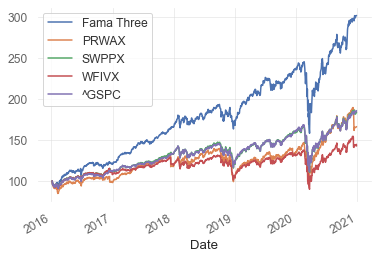

In [34]:
comparisons = ["^GSPC", "WFIVX", "PRWAX", "SWPPX"]
sp_500 = yf.download(tickers=comparisons, start=start, end=end, threads = False)
sp_500 = sp_500.loc[:,('Close')]
sp_500_total_cum_return = ((sp_500.iloc[-1] - sp_500.iloc[0]) / sp_500.iloc[0])*100
display(sp_500_total_cum_return)
sp_500_daily = sp_500.pct_change().fillna(100)[1:]
compare_port = (sp_500_daily + 1).cumprod()
compare_port *= 100
compare_port = pd.DataFrame(compare_port)
display(compare_port)

Y_cum = data[assets].pct_change().fillna(0)[1:]
for tick in W3.index:
    Y_cum.loc[:,tick] *= W3.loc[tick].values
port_ret = Y_cum.sum(axis=1)
Y_cum_ret = (port_ret + 1).cumprod()
Y_cum_ret *= 100
print(Y_cum_ret)



pfcr = pd.DataFrame(Y_cum_ret)
pfcr.columns = ["Fama Three"]
newdf = pfcr.join(compare_port)

newdf.plot()

                    Strategy
------------------  ----------
Start Period        2016-01-05
End Period          2020-12-29
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   201.38%
CAGR%               24.76%

Sharpe              1.24
Sortino             1.76
Sortino/√2          1.24

Max Drawdown        -35.5%
Longest DD Days     133

Gain/Pain Ratio     0.29
Gain/Pain (1M)      2.43

Payoff Ratio        0.99
Profit Factor       1.29
Common Sense Ratio  1.19
CPC Index           0.72
Tail Ratio          0.92
Outlier Win Ratio   4.2
Outlier Loss Ratio  4.61

MTD                 1.74%
3M                  15.75%
6M                  30.86%
YTD                 27.84%
1Y                  27.4%
3Y (ann.)           21.89%
5Y (ann.)           24.76%
10Y (ann.)          24.76%
All-time (ann.)     24.76%

Avg. Drawdown       -1.5%
Avg. Drawdown Days  12
Recovery Factor     5.67
Ulcer Index         1.16


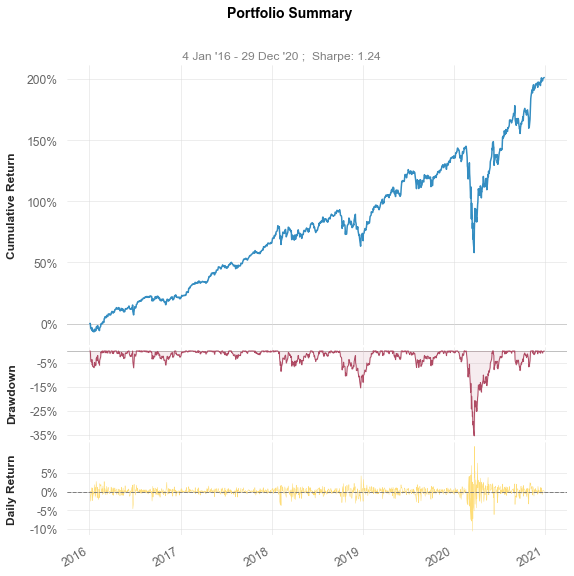

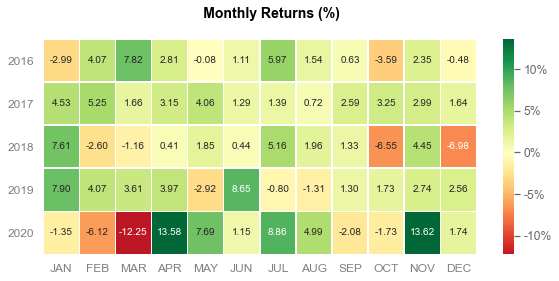

In [35]:
qs.reports.basic(port_ret)

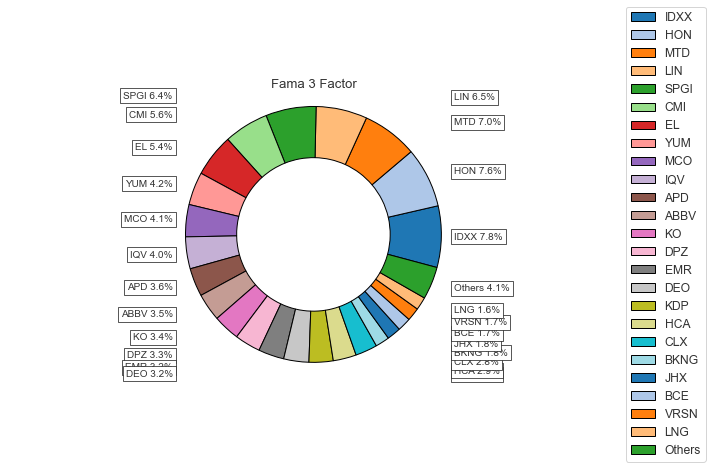

In [24]:
ax = plf.plot_pie(w=W3, title='Fama 3 Factor', others=0.05, nrow = 25, cmap = "tab20", height=6, width=10, ax=None)

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)


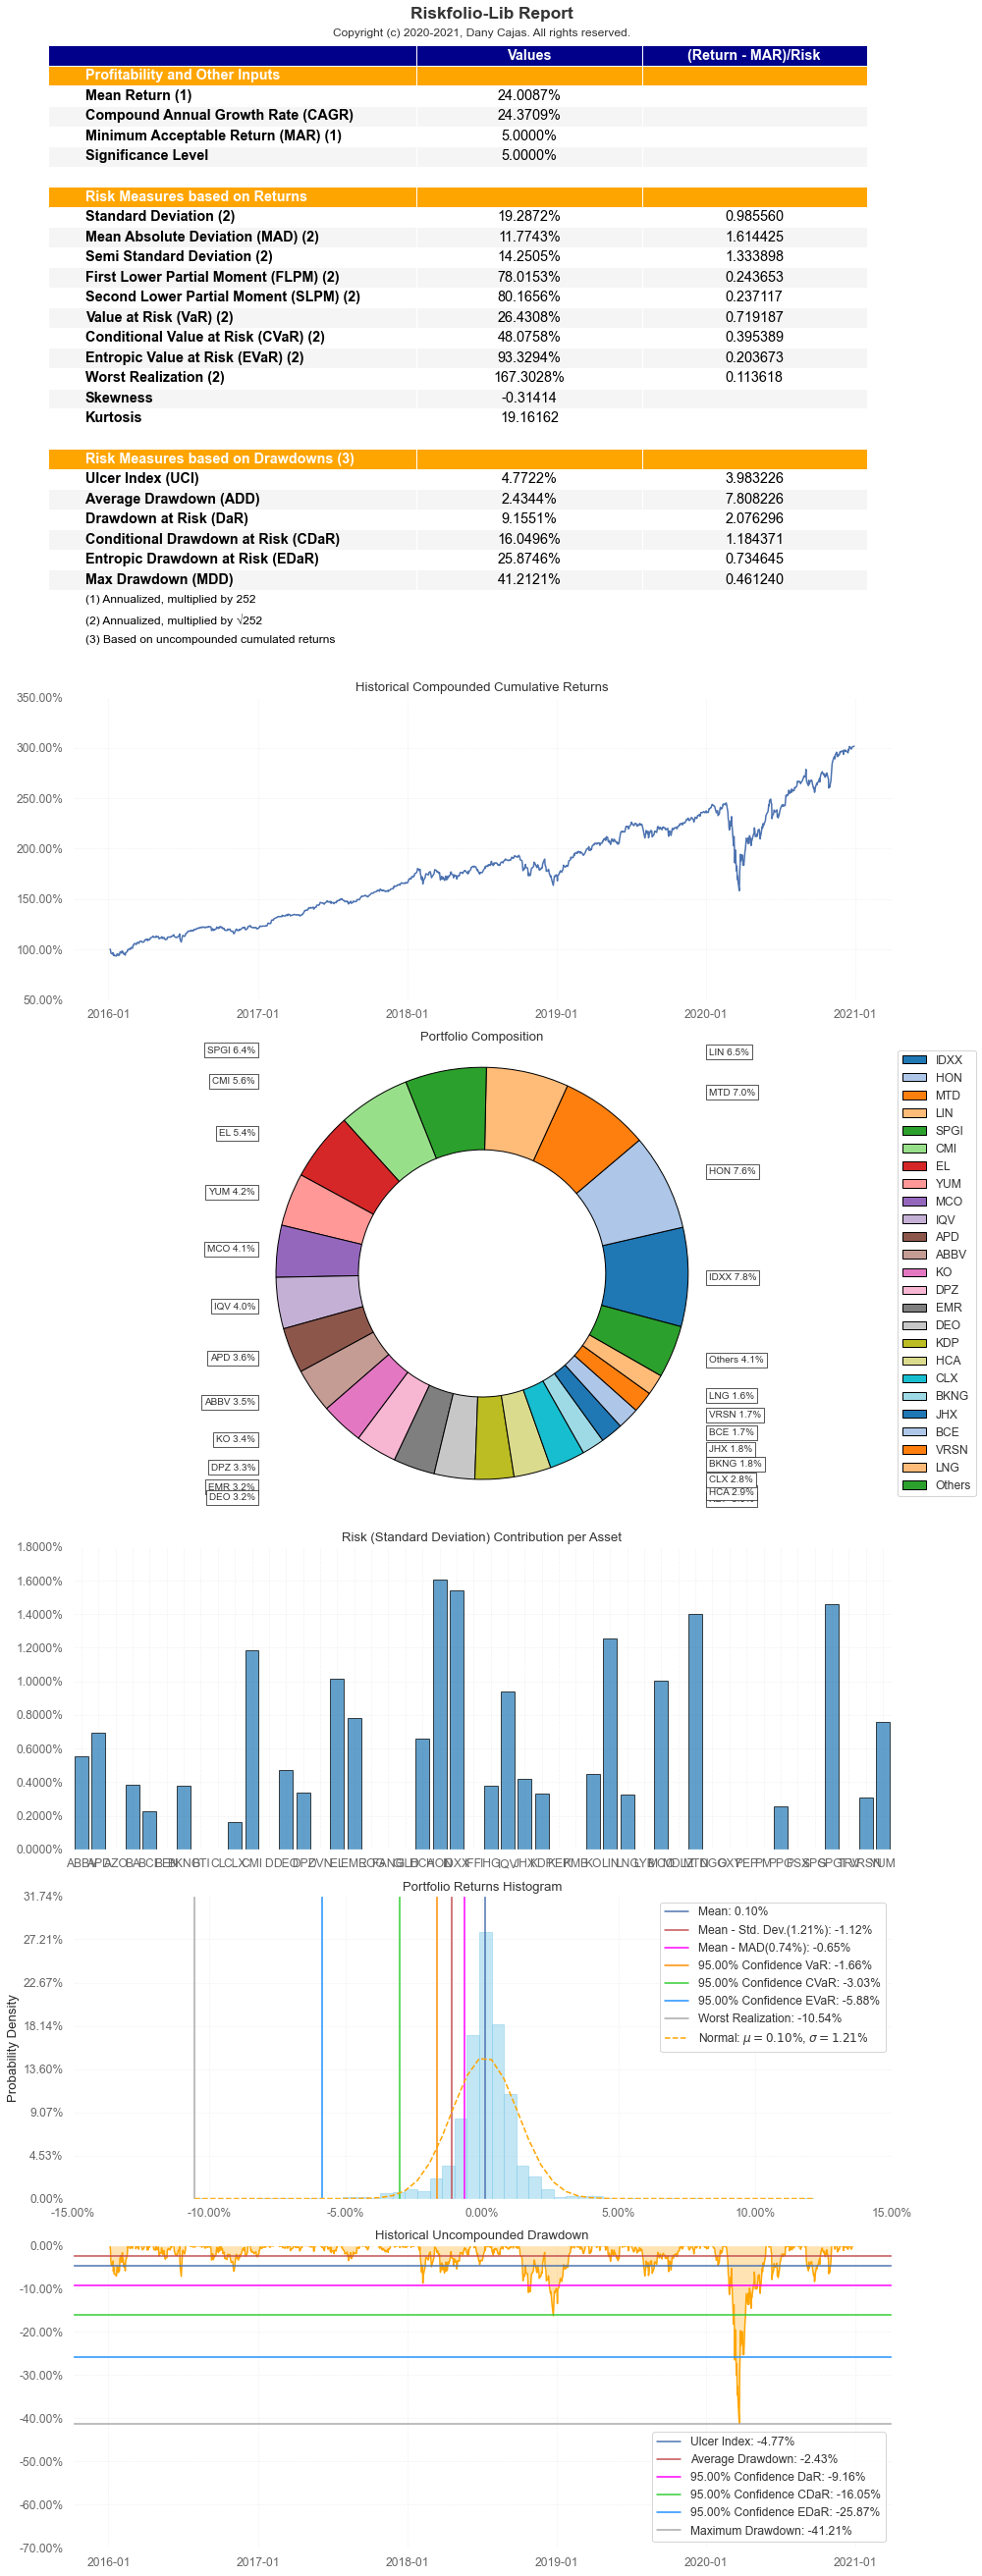

In [25]:
ax_report = rp.jupyter_report(port_diff, w=W3, rm='MV', rf=0.05, alpha=0.05, height=6, width=14,
                       others=0.05, nrow=25)

In [26]:
five_factor = pd.read_csv('FF_five.csv', index_col=0, header=0)/100
five_factor = five_factor.loc[start: end][:-2]
x = five_factor[['Mkt-RF', 'SMB', 'HML', 'RMW','CMA']].values
y = port_diff.values
reg = LinearRegression().fit(x, y)
B = np.matrix(reg.coef_).T

In [27]:
Sigma_F = np.cov(x.T)
error = y - reg.predict(x)
Sigma_e = np.diag(np.var(error, ddof = 1, axis = 0))
mu_fama = np.matrix(np.mean(reg.predict(x), axis = 0))
Sigma_fama = B.T * Sigma_F *  B + Sigma_e_2
w_fama_five = Max_Sharpe(mu_fama, Sigma_fama)

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 4 times so far.

  warnings.warn(msg, UserWarning)


In [28]:
W4 = pd.DataFrame(w_fama_five, index = assets, columns = ['Fama Five'])
display(W4)

Fama Five
ABBV  3.711113e-02
APD   3.549018e-02
AZO   7.206392e-09
BA    1.040519e-02
BCE   1.769384e-02
BEN   1.663981e-09
BKNG  1.690582e-02
BTI   1.722299e-09
CL    8.926404e-09
CLX   3.133248e-02
CMI   5.706704e-02
D     3.645543e-09
DEO   2.844816e-02
DPZ   3.527176e-02
DVN   6.033195e-10
EL    5.560634e-02
EMR   2.916383e-02
EOG   7.838630e-10
FANG  9.771422e-10
GILD  1.010941e-09
HCA   2.646721e-02
HON   7.126355e-02
IDXX  8.299894e-02
IFF   3.121304e-09
IHG   1.098802e-02
IQV   3.638000e-02
JHX   1.494254e-02
KDP   3.235583e-02
KEP   4.653489e-10
KMB   1.655117e-07
KO    3.680162e-02
LIN   6.866837e-02
LNG   1.289145e-02
LYB   1.706571e-09
MCO   4.303720e-02
MDLZ  1.025972e-06
MTD   7.454218e-02
NGG   3.903184e-09
OXY   4.483470e-10
PEP   3.755863e-08
PM    1.937537e-09
PPG   6.711676e-03
PSX   1.702677e-09
SPG   7.543008e-10
SPGI  6.924166e-02
TRV   1.256955e-09
VRSN  2.183738e-02
YUM   3.637533e-02

In [29]:
W4_dup = W4.reset_index()
W4_dup.columns = ["Name", "Allocation"]
df_pf_fama5 = build_portfolio(names=list(W4.index), start_date = start, end_date = end, data_api="yfinance", pf_allocation = W4_dup)

print(f"Sharpe Ratio: {df_pf_fama5.comp_sharpe()}")
#df_pf_fama5.properties()

[*********************100%***********************]  48 of 48 completed
Sharpe Ratio: 1.2458085494720863


[*********************100%***********************]  4 of 4 completed


PRWAX    66.169272
SWPPX    83.268981
WFIVX    42.547109
^GSPC    85.179811
dtype: float64

PRWAX       SWPPX       WFIVX       ^GSPC
Date                                                      
2016-01-05   99.975533  100.193048  100.171335  100.201223
2016-01-06   99.021523   98.938224   98.914903   98.887044
2016-01-07   96.061642   96.589448   96.516273   96.543377
2016-01-08   95.009783   95.527672   95.431176   95.497004
2016-01-11   94.863008   95.624194   95.431176   95.578489
...                ...         ...         ...         ...
2020-12-22  164.995096  181.306302  143.061102  183.203320
2020-12-23  165.092945  181.435005  143.232436  183.339955
2020-12-24  165.166328  182.110678  143.632206  183.988354
2020-12-28  166.071423  183.687260  144.545969  185.593197
2020-12-29  166.169272  183.268981  142.547109  185.179811

[1256 rows x 4 columns]

Date
2016-01-05    100.165142
2016-01-06     99.079649
2016-01-07     96.619872
2016-01-08     95.730266
2016-01-11     95.565141
                 ...    
2020-12-22    303.721499
2020-12-23    304.386676
2020-12-24    305.685543
2020-12-28    306.479022
2020-12-29    306.493850
Length: 1256, dtype: float64


<AxesSubplot:xlabel='Date'>

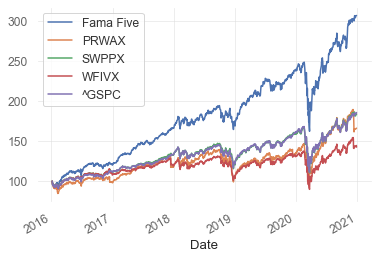

In [30]:
comparisons = ["^GSPC", "WFIVX", "PRWAX", "SWPPX"]
sp_500 = yf.download(tickers=comparisons, start=start, end=end, threads = False)
sp_500 = sp_500.loc[:,('Close')]
sp_500_total_cum_return = ((sp_500.iloc[-1] - sp_500.iloc[0]) / sp_500.iloc[0])*100
display(sp_500_total_cum_return)
sp_500_daily = sp_500.pct_change().fillna(100)[1:]
compare_port = (sp_500_daily + 1).cumprod()
compare_port *= 100
compare_port = pd.DataFrame(compare_port)
display(compare_port)

Y_cum = data[assets].pct_change().fillna(0)[1:]
for tick in W4.index:
    Y_cum.loc[:,tick] *= W4.loc[tick].values
port_ret = Y_cum.sum(axis=1)
Y_cum_ret = (port_ret + 1).cumprod()
Y_cum_ret *= 100
print(Y_cum_ret)



pfcr = pd.DataFrame(Y_cum_ret)
pfcr.columns = ["Fama Five"]
newdf = pfcr.join(compare_port)

newdf.plot()

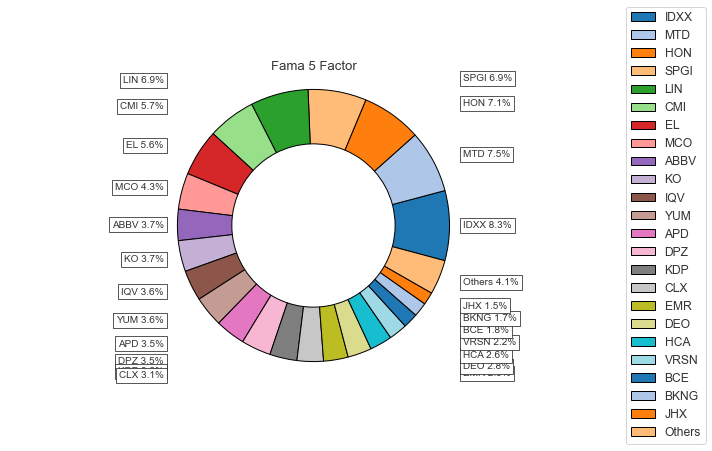

In [31]:
ax = plf.plot_pie(w=W4, title='Fama 5 Factor', others=0.05, nrow = 25, cmap = "tab20", height=6, width=10, ax=None)

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)


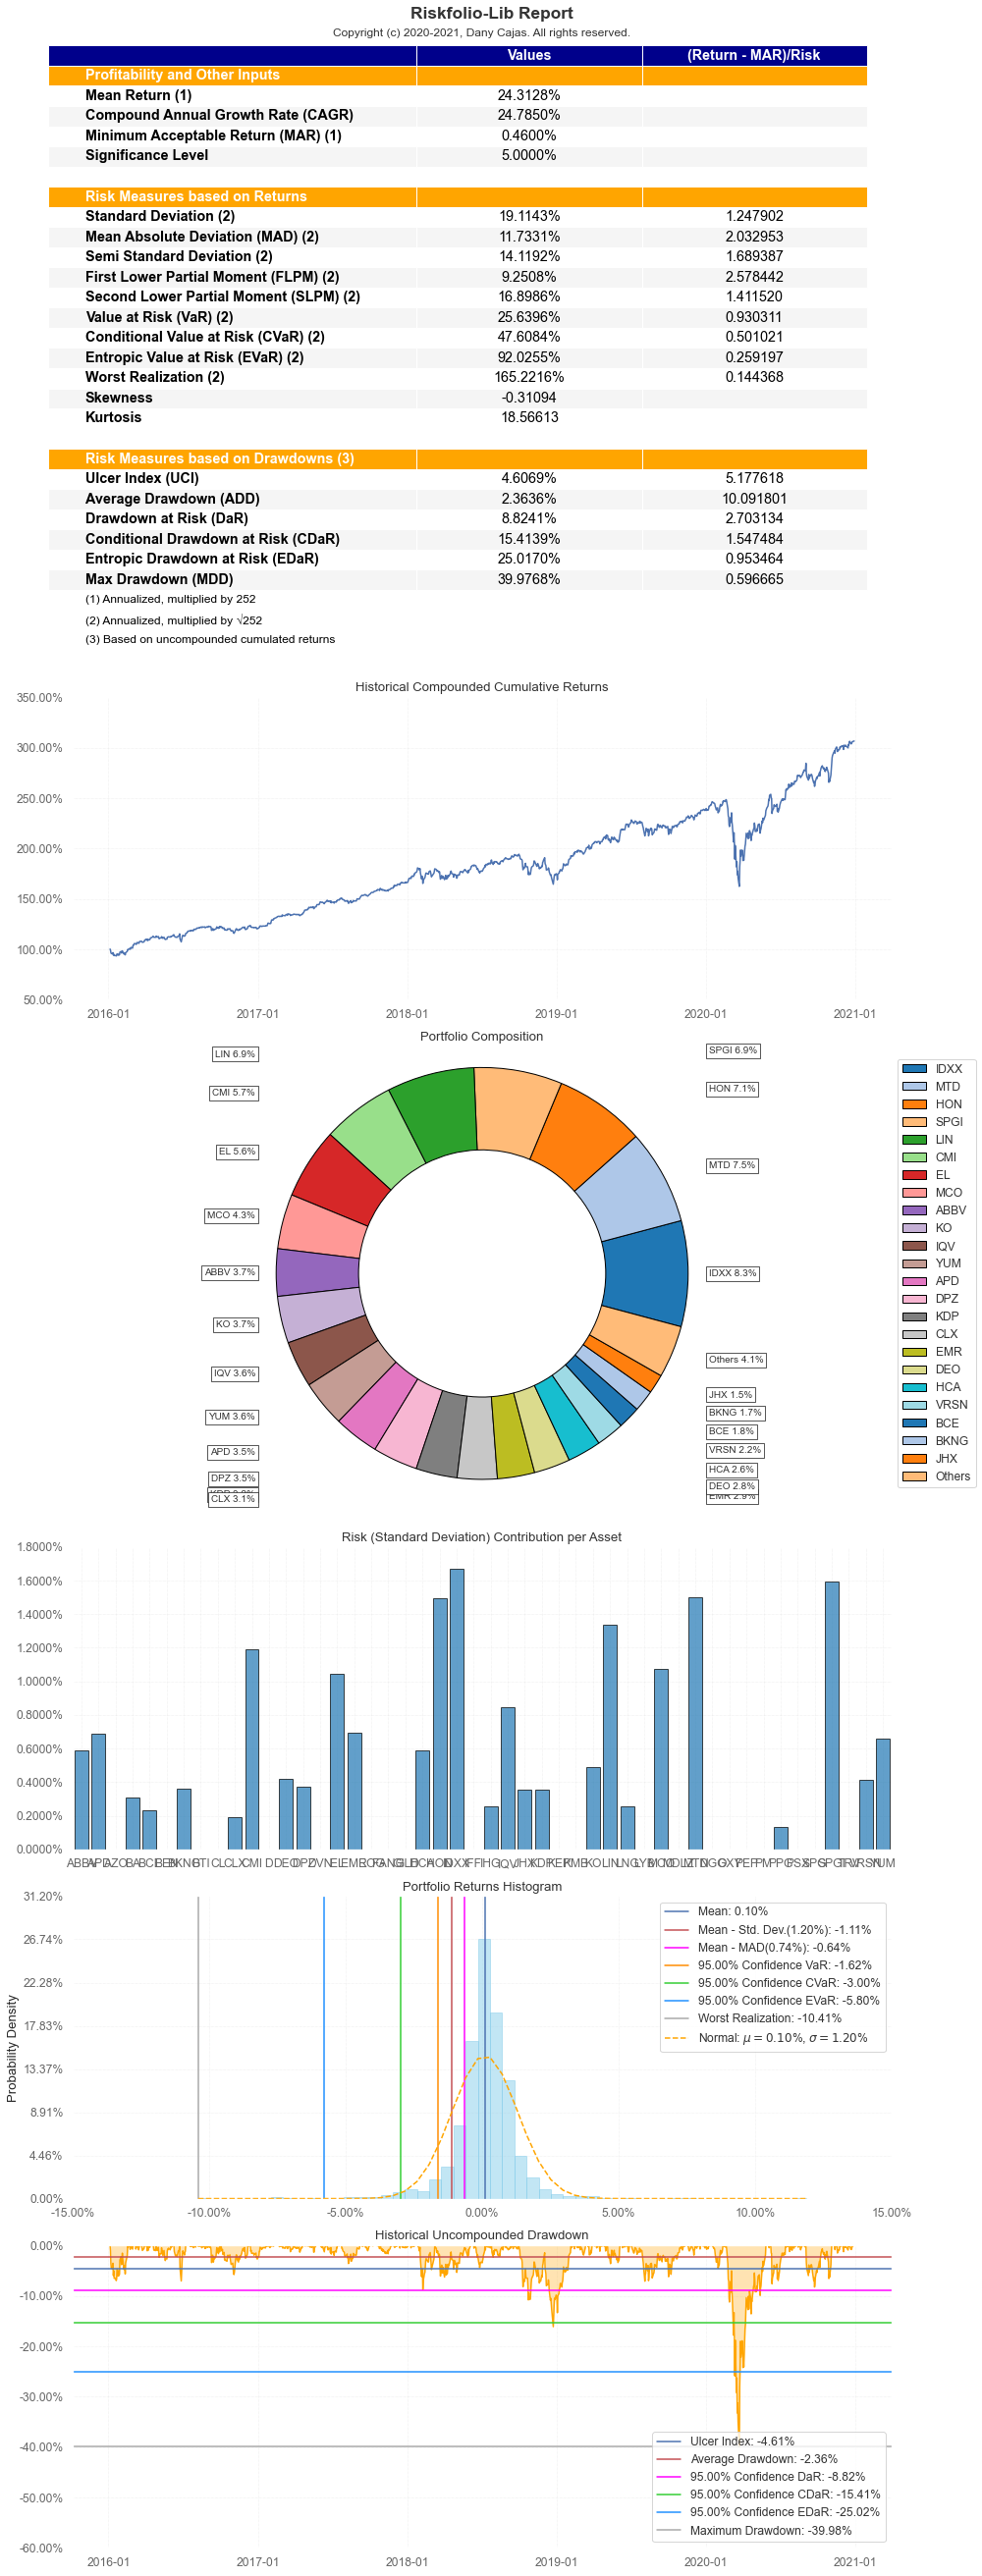

In [32]:
ax_report = rp.jupyter_report(port_diff, w=W4, rm='MV', rf=five_factor['Mkt-RF'][-1], alpha=0.05, height=6, width=14,others=0.05, nrow=25)

                    Strategy
------------------  ----------
Start Period        2016-01-05
End Period          2020-12-29
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   206.49%
CAGR%               25.18%

Sharpe              1.27
Sortino             1.8
Sortino/√2          1.27

Max Drawdown        -34.66%
Longest DD Days     133

Gain/Pain Ratio     0.3
Gain/Pain (1M)      2.56

Payoff Ratio        0.97
Profit Factor       1.3
Common Sense Ratio  1.23
CPC Index           0.72
Tail Ratio          0.95
Outlier Win Ratio   4.23
Outlier Loss Ratio  4.57

MTD                 1.66%
3M                  15.03%
6M                  29.89%
YTD                 28.78%
1Y                  28.35%
3Y (ann.)           22.47%
5Y (ann.)           25.18%
10Y (ann.)          25.18%
All-time (ann.)     25.18%

Avg. Drawdown       -1.48%
Avg. Drawdown Days  12
Recovery Factor     5.96
Ulcer Index         1.15


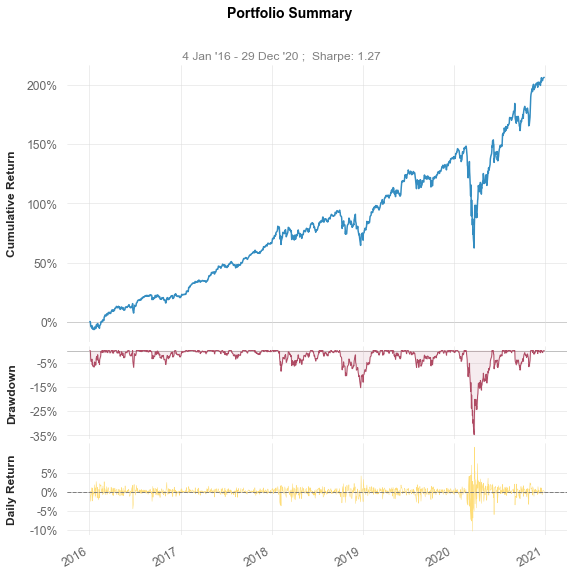

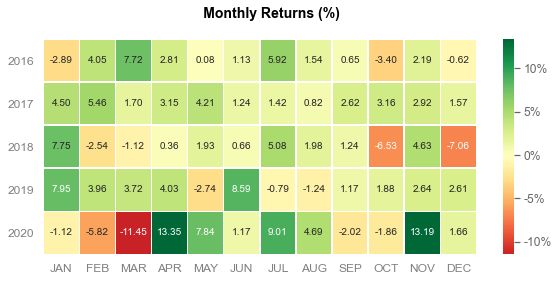

In [33]:
qs.reports.basic(port_ret)